# Standby Burst Forecast for Electrical Appliances

Electric power is an important and a scarce resource. Especially in the developing countries, this is a big issue as those countries do not have enough power generation capacity and a considerable portion of their population do not have non-stop access to electricity, as the governments employ various load management strategies. Due to the lower demand supply ratio, the power tariff is also high which makes it less affordable for people who are already living on low household income. In such a scenario, efficient household power management could help the households conserve energy and reduce their spending. It will, in turn, also help the governments have more energy available in the grid and distribute it to the consumers.

Among various strategies for controlling household power consumption, one could be the use of electrical appliances that have built-in energy management policies. Like, many modern devices switch to stand-by mode when they are not in use. During the stand-by mode, the devices consume relatively low energy while waiting for the event to turn it back to the on/working state. For example, a refrigerator/freezer is usually always plugged-in in a normal household. A refrigerator’s compressor is in working state while its temperature is higher than the desired one. In case the temperature is within desirable range, the refrigerator switches to stand-by mode, consuming a low power only to keep track of temperature and automatically switch it back to the working mode when the temperature rises above the desired range. Such a policy is indeed helpful in saving a lot of energy but it still has some energy leakage during the stand-by mode as some power, even if it is relatively low, is consumed. 

A better policy could be to rather switch such a device off, instead of putting into stand-by mode, and turn it back on when required. Now, as there would be no mechanism of tracking the actual temperature and device state switching requirement, we need to develop a method to decide when to change the state of the device, from stand-by to on or vice versa. This is where data science could help. In fact, we could use machine learning algorithms to develop a model that forecasts the future state of a device based on past power usage data. This will help us decide when to change the state of a device. For example, after running compressor for let’s say 5 minutes, the compressor switches to stand-by mode for 2.2 minutes. So if we are able to forecast these bursts reliably, we could switch the compressor, that started running state at time t, to off state at t+5 and switch it back to the running state at t+7.7. This will help us conserve the energy that the refrigerator would use being in stand-by mode from t+5 to t+7.7.

The important tasks of this work are:

1. Exploring and analyzing power consumption of various electrical appliances in a household setting
2. Studying the suitability of various machine learning models to forecast the state of an electrical appliance
3. Tune a machine learning model to reliably forecast the state of an electrical appliance
4. Calculate the advantage, in terms of energy conserved, of employing such technique
5. Document and publish my work on Github



## Data Set

**REFIT Electrical Load Measurements (University of Strathclyde) – 490 MB**

This dataset includes cleaned electrical consumption data in Watts for 20 households at aggregate and appliance level, timestamped and sampled at 8 second intervals.

URL: https://www.refitsmarthomes.org/datasets/ 


## The Code

Let's first import the required libraries

In [8]:
# recursive multi-step forecast with linear algorithms
import pandas as pd
import numpy
import math 

from math import sqrt, nan
from numpy import split, isnan
from numpy import array
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from matplotlib import pyplot
from matplotlib import gridspec
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [9]:
PREDICT_LENGTH = 30 # This variable controls the number of hours to forecast

The dataset is downloaded from the above link. We load it into a pandas dataframe below

In [10]:
df = read_csv('clean_house1.csv', sep=',')
df.columns = ['Time','Unix','Aggregate','Fridge', 'Chest Freezer', 'Upright Freezer', 'Tumble Dryer',
'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site', 'Electric Heater', 'issue']

### Exploratory Data Analysis and Preparation

Let's first just have a rough idea of the dataset

In [11]:
df.head()

,Time,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,issue
0,2013-10-09 13:06:17,1381323977,523,74,0,69,0,0,0,0,0,1,0
1,2013-10-09 13:06:31,1381323991,526,75,0,69,0,0,0,0,0,1,0
2,2013-10-09 13:06:46,1381324006,540,74,0,68,0,0,0,0,0,1,0
3,2013-10-09 13:07:01,1381324021,532,74,0,68,0,0,0,0,0,1,0
4,2013-10-09 13:07:15,1381324035,540,74,0,69,0,0,0,0,0,1,0


The first two attributes represent timestamp in differnet formats. The third one is aggregate houehold power consumption while the rest of the columns, except the last one, represent the powe consumption of individual electrical appliances.

In [12]:
df.describe()

,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,issue
count,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06,6.960008e+06
mean,1.409144e+09,4.811385e+02,1.753831e+01,1.655047e+01,2.900873e+01,1.844441e+00,1.102860e+01,1.116492e+01,2.473279e+00,5.803410e+00,6.947503e+01,8.359617e-03
std,1.579852e+07,8.128927e+02,4.309098e+01,2.883743e+01,3.800527e+01,5.611159e+01,1.439160e+02,1.567903e+02,1.192701e+01,1.317050e+01,2.557986e+02,9.104798e-02
min,1.381324e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.396639e+09,1.850000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,1.409931e+09,2.420000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.422401e+09,4.270000e+02,0.000000e+00,4.500000e+01,7.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.436529e+09,2.915900e+04,3.584000e+03,3.452000e+03,3.657000e+03,3.584000e+03,3.072000e+03,2.525000e+03,2.094000e+03,3.584000e+03,2.119000e+03,1.000000e+00


In [13]:
df_filter = df.copy()

df_filter['datetime'] = pd.to_datetime(df_filter['Time']) 
df_filter = df_filter.set_index('datetime')
df_filter.drop(df_filter.columns[[0,1,2,-1]], axis=1, inplace=True)


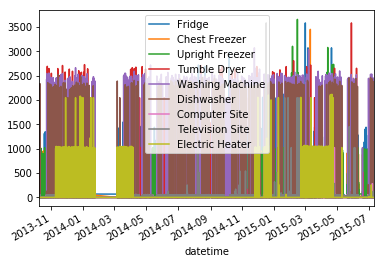

In [14]:
#plot all the attributes
df_filter.plot()
pyplot.show()

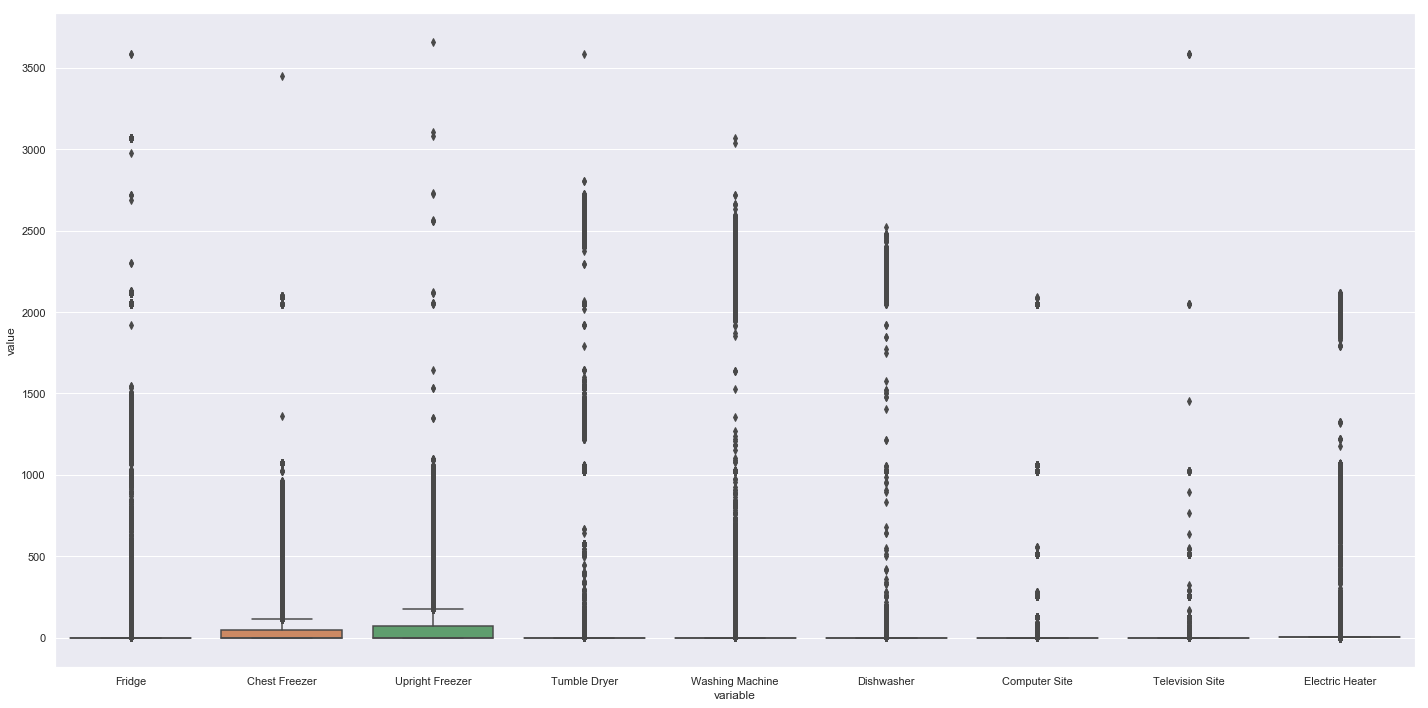

In [15]:
# visualize the data using box-plot
sns.set(rc={'figure.figsize':(20,10)})
sns.boxplot(x="variable", y="value", data=pd.melt(df_filter))
pyplot.tight_layout()
pyplot.show()

We have too many outliers as shown in the above plot, so lets ignore them for the moment to have a better idea of the spread

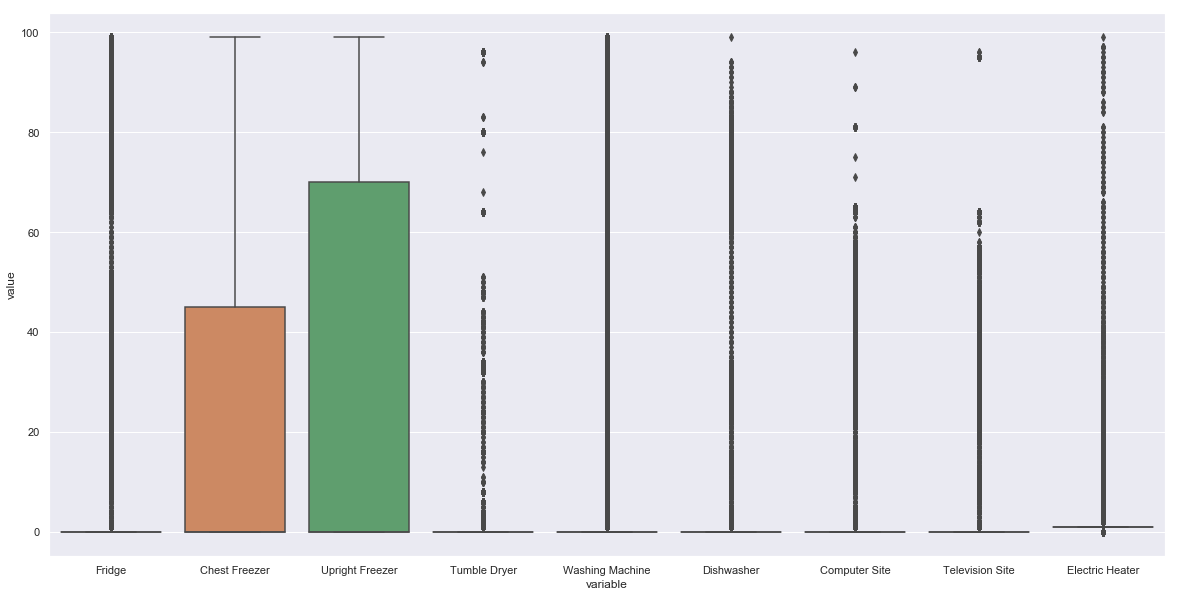

In [16]:
df_filter = df_filter[(df_filter < 100).all(axis=1)]
sns.boxplot(x="variable", y="value", data=pd.melt(df_filter))
pyplot.show()

Most of the recordings for appliances are zeroes as the electrical appliances are not always in working mode. The best candidates for our problem are chest freezer and upright freezer as their 75th percentile represents working mode of those appliances. Therefore, in the following, the focus will be on chest freezer.

In [17]:
df_chestfreezer=df[['Time', 'Chest Freezer']]

df_chestfreezer['Time'] = pd.to_datetime(df_chestfreezer['Time']) 
df_chestfreezer = df_chestfreezer.set_index('Time')

C:\Users\Usman\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


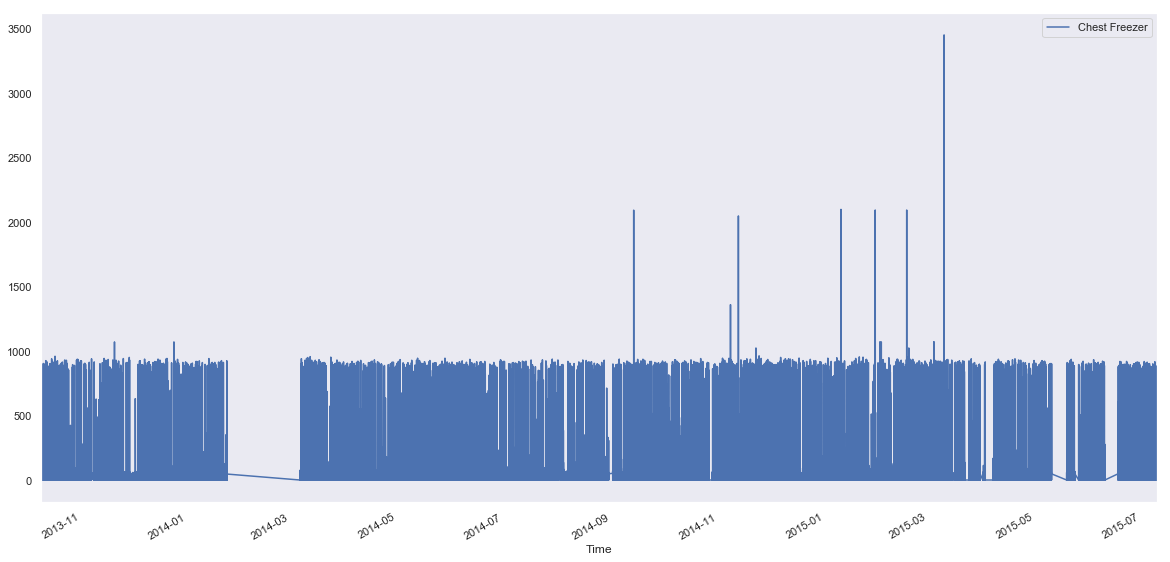

In [18]:
pyplot.rcParams["axes.grid"] = False # for removing the gridlines
df_chestfreezer.plot()

The dataset being too large is restricting the in-depth analysis. Therefore, we replace the outliers with the borderline values an select a one month window for further exploration

In [19]:
df_chestfreezer['Chest Freezer'] = [100 if x>100 else x for x in df_chestfreezer['Chest Freezer']]
df_chestfreez=df_chestfreezer.loc[(df_chestfreezer.index>'2013-10-09 13:07:00') & (df_chestfreezer.index<'2013-11-08 11:59:59')]

In [20]:
# df_chestfreez.plot()

Now, lets have a look at single day data to understand further

In [21]:
df_day = df_chestfreez.loc[(df_chestfreez.index>'2013-10-09 13:07:00') & (df_chestfreez.index<'2013-10-09 23:59:59')]
# df_day.plot()

From the above above, we observe that the appliance switches states periodically, as expected. We can safely decide that the running state power of the appliance is above 30. Therefore the appliance is assumed to be in the standby mode when dropping below the cutoof, i.e.30.

In [22]:
STANDBY_CUTOFF = 30

# horiz_line_data = numpy.array([30 for i in range(len(df_day))])
# pyplot.plot(df_day.index, df_day['Chest Freezer'])
# pyplot.plot(df_day.index, horiz_line_data, 'r-') 

In [23]:
# horiz_line_data = numpy.array([30 for i in range(len(df_chestfreez))])
# pyplot.plot(df_chestfreez.index, df_chestfreez['Chest Freezer'])
# pyplot.plot(df_chestfreez.index, horiz_line_data, 'r-') 

Next, we plot histogrm and pie chart to visualize the distribution of on and stand-by states of the power consumption

In [24]:
# pyplot.hist(df_chestfreez['Chest Freezer'])
# pyplot.ylabel('Power');

Next, we resample the data to minute level and add another column for the state of appliance.

In [25]:
data = df_chestfreez.resample('60s').mean()
data.columns = ['power']
data['state'] = data['power'].apply(lambda x: 0 if x<= STANDBY_CUTOFF else 1)

In [26]:
# by_state = data.groupby('state')['power'].count().reset_index()
# by_state = data.groupby('state')['power'].count().reset_index()
# pyplot.pie(
#     by_state['power'],
#     labels = ['Stand-by','Running'],
#     # with no shadows
#     shadow=False,
#     # with the start angle at 90%
#     startangle=90,
#     # with the percent listed as a fraction
#     autopct='%1.1f%%',
#     )


Now, let us deal witht the missing values by making them zeroes

In [27]:
# mark all missing values
data.replace('?', nan, inplace=True)
# make dataset numeric
data = data.astype('float32')

In [28]:
# fill missing values with a zero
def fill_missing(values):    
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = 0
                
# fill missing
fill_missing(data.values)

In [29]:
data.to_csv('cfreezer_consumption.csv')

### Evaluation Metric

This notebook studies the forecasting of state of appliance using classification algorithms. Therefore, we set up the relevant evaluation metrics.

#### F1-Score

In [30]:
def evaluate_fscore(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        
        f1 = f1_score(actual[:, i], predicted[:, i])        
        scores.append(f1)        
      
    return scores

#### Accuracy

In [31]:
def evaluate_accuracy(actual, predicted):
    scores = list()
    
    for i in range(actual.shape[1]):
        
        ac = accuracy_score(actual[:, i], predicted[:, i])        
        scores.append(ac) 
        
    return scores

#### Confusion Matrix

In [32]:
def plot_conf_matrix(actual, predicted):    

    cols = 4
    rows = int(math.ceil(min(actual.shape[1],12) / cols))

    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.2) 
    fig = pyplot.figure(constrained_layout=True) 
    fig.suptitle("Confusion Matrices "+ str(min(actual.shape[1],12))+" minutes", fontsize=14)
    fig.set_size_inches(25, 20)    

    for i in range(min(actual.shape[1],12)):
        cnf_matrix = confusion_matrix(actual[:, i], predicted[:, i], labels=[1,0])
        numpy.set_printoptions(precision=2)
        
        ax = fig.add_subplot(gs[i])
        plot_confusion_matrix(fig, ax, cnf_matrix, classes=['On','Standby'],normalize= False,  title='Minute '+str(i+1))
    

In [33]:
def plot_confusion_matrix(fig, ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = numpy.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes, rotation='vertical')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

#### Precision (Specificity)

In [34]:
def evaluate_precision(actual, predicted):
    scores = list()
    
    for i in range(actual.shape[1]):
        
        ps = precision_score(actual[:, i], predicted[:, i])        
        scores.append(ps) 
        
    return scores

#### Recall (Sensitivity)

In [35]:
def evaluate_recall(actual, predicted):
    scores = list()
    
    for i in range(actual.shape[1]):
        
        rc = recall_score(actual[:, i], predicted[:, i])        
        scores.append(rc) 
        
    return scores

### Train Test Split

In [36]:
# split a univariate dataset into train/test sets
def split_dataset(data):
            
    trainsize = int(len(data)*-0.2)
    train, test = data[:trainsize], data[trainsize:]
    
    #organize into hour
    train = train[0:-(len(train)%PREDICT_LENGTH)]
    test = test[0:-(len(test)%PREDICT_LENGTH)]
    
    train = array(split(train, len(train)/PREDICT_LENGTH))
    test = array(split(test, len(test)/PREDICT_LENGTH))
    
    return train, test

### Modeling

In [37]:
def to_series(data):
    # extract just the total power from each week
    series = [h for h in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

In [38]:
# convert history into inputs and outputs
def to_supervised(history, n_input):
    # convert history to a univariate series
    
    data = to_series(history)
    X, y = list(), list()
        
    ix_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        ix_end = ix_start + n_input
        # ensure we have enough data for this instance
        if ix_end < len(data):
            X.append(data[ix_start:ix_end])
            y.append(data[ix_end])
        # move along one time step
        ix_start += 1
        
    return array(X), array(y)

In [39]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [40]:
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
    # prepare data
    train_x, train_y = to_supervised(history, n_input)
    # make pipeline    
    pipeline = make_pipeline(model)
    # fit the model
    pipeline.fit(train_x, train_y)
    # predict the next minutes, recursively
    yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
    return yhat_sequence

In [41]:
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
    yhat_sequence = list()
    input_data = [x for x in input_x]
    for j in range(n_input):
        # prepare the input data
        X = array(input_data[-n_input:]).reshape(1, n_input)
        # make a one-step forecast
        yhat = model.predict(X)    #[0]    
       
        # add to the result
        yhat_sequence.append(yhat)
        # add the prediction to the input
        input_data.append(yhat)
    return yhat_sequence

In [42]:
# evaluate a single model
def evaluate_model(model, train, test, n_input):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the the nex PREDICT_LENGTH minutes
        yhat_sequence = sklearn_predict(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next minutes
        history.append(test[i, :])
    predictions = array(predictions)
    
    accuracy = evaluate_accuracy(test[:, :], predictions)
    f1 = evaluate_fscore(test[:, :], predictions)
    precision = evaluate_precision(test[:, :], predictions)
    recall = evaluate_recall(test[:, :], predictions)
    plot_conf_matrix(test[:, :], predictions)
    
    return accuracy, f1, precision, recall

In [43]:
# prepare a list of ml models
def get_models(models=dict()):
    # linear models
    models['logR'] = LogisticRegression(C=0.01, solver='liblinear')
    models['dt'] = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    models['mlp'] = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)
    models['SVM'] = SVC(gamma='auto')
    models['KNN'] = KNeighborsClassifier(n_neighbors=3)
    
    
    print('Defined %d models' % len(models))
    return models

In [44]:
# summarize scores
def summarize_scores(name, accuracy, f1, precision, recall):
    accu = ', '.join(['%.1f' % a for a in accuracy])
    fs = ', '.join(['%.1f' % f for f in f1])
    ps = ', '.join(['%.1f' % p for p in precision])
    rc = ', '.join(['%.1f' % r for r in recall])
    print('%s: \n\tAccuracy: %s \n\tF_Score: %s \n\tPrecision: %s \n\tRecall: %s' % (name, accu, fs, ps, rc))

Defined 5 models

 Now evaluating logR...

logR: 
	Accuracy: 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.8, 0.9, 0.9 
	F_Score: 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.9, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8 
	Precision: 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.8, 0.8, 0.7, 0.8, 0.8, 0.7, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8 
	Recall: 0.9, 0.9

C:\Users\Usman\Anaconda3\lib\site-packages\matplotlib\figure.py:2317: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "



 Now evaluating SVM...

SVM: 
	Accuracy: 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8 
	F_Score: 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.6, 0.7, 0.7, 0.7 
	Precision: 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0 
	Recall: 0.9, 0.9, 0.8, 0.8, 0.8, 0.

C:\Users\Usman\Anaconda3\lib\site-packages\matplotlib\figure.py:2317: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "



 Now evaluating mlp...

mlp: 
	Accuracy: 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9 
	F_Score: 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.8, 0.9, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8 
	Precision: 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 1.0, 0.9, 0.9, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.8, 0.7, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8 
	Recall: 0.9, 0.9, 0.8, 0.8, 0.8, 0.

C:\Users\Usman\Anaconda3\lib\site-packages\matplotlib\figure.py:2317: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "



 Now evaluating dt...

dt: 
	Accuracy: 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8 
	F_Score: 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.6, 0.7, 0.7, 0.7 
	Precision: 0.9, 1.0, 0.9, 0.9, 1.0, 1.0, 0.9, 0.9, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0 
	Recall: 0.9, 0.9, 0.8, 0.8, 0.8, 0.8,

C:\Users\Usman\Anaconda3\lib\site-packages\matplotlib\figure.py:2317: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "



 Now evaluating KNN...

KNN: 
	Accuracy: 1.0, 0.9, 0.9, 0.9, 1.0, 1.0, 0.9, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 0.9, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 0.9, 1.0, 0.9 
	F_Score: 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9 
	Precision: 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9 
	Recall: 0.9, 0.9, 0.9, 0.9, 0.9, 0.

C:\Users\Usman\Anaconda3\lib\site-packages\matplotlib\figure.py:2317: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
C:\Users\Usman\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


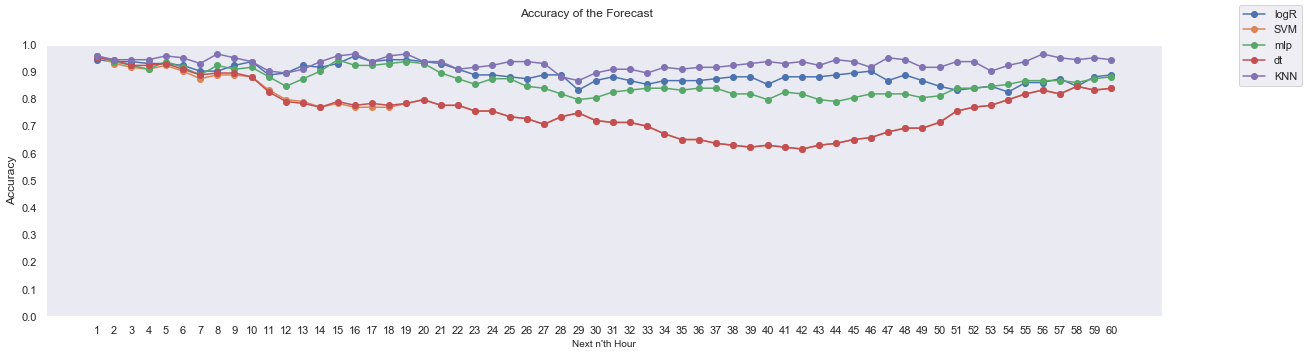

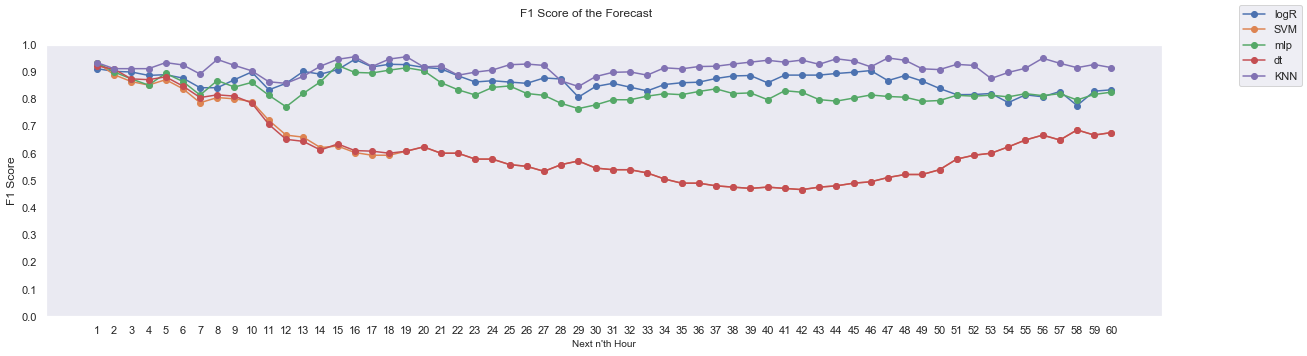

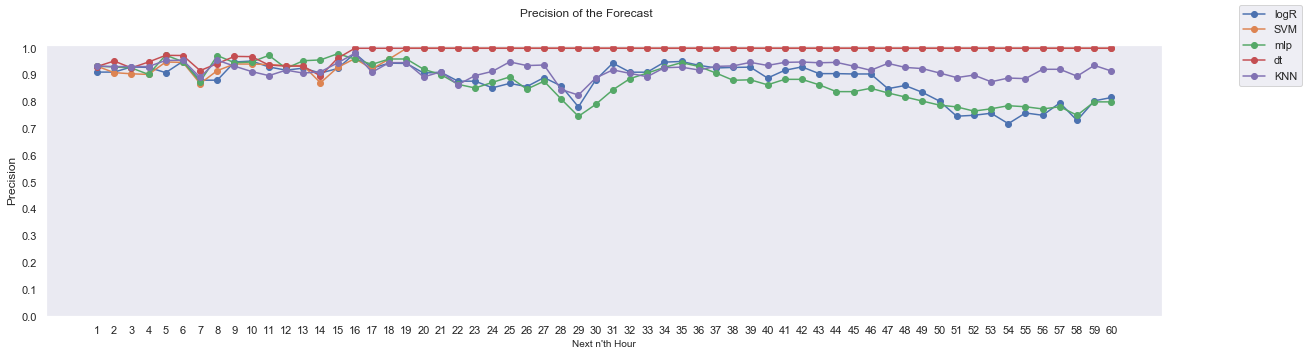

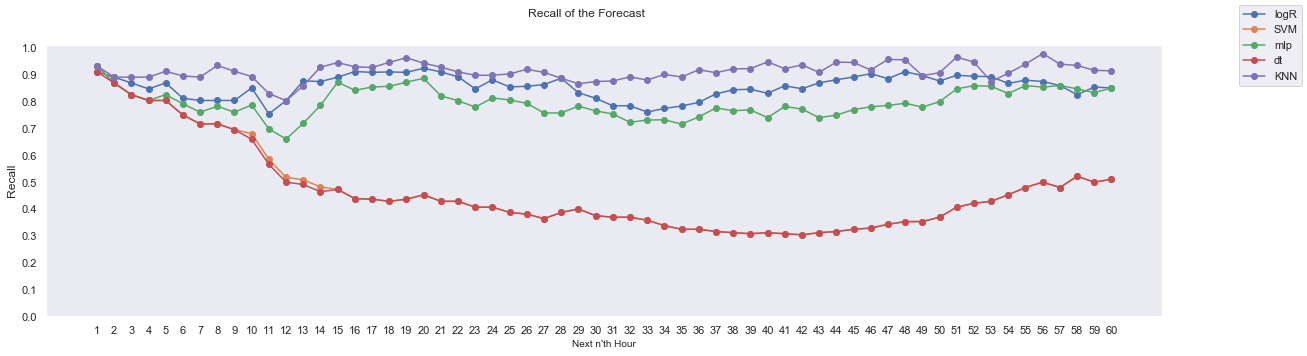

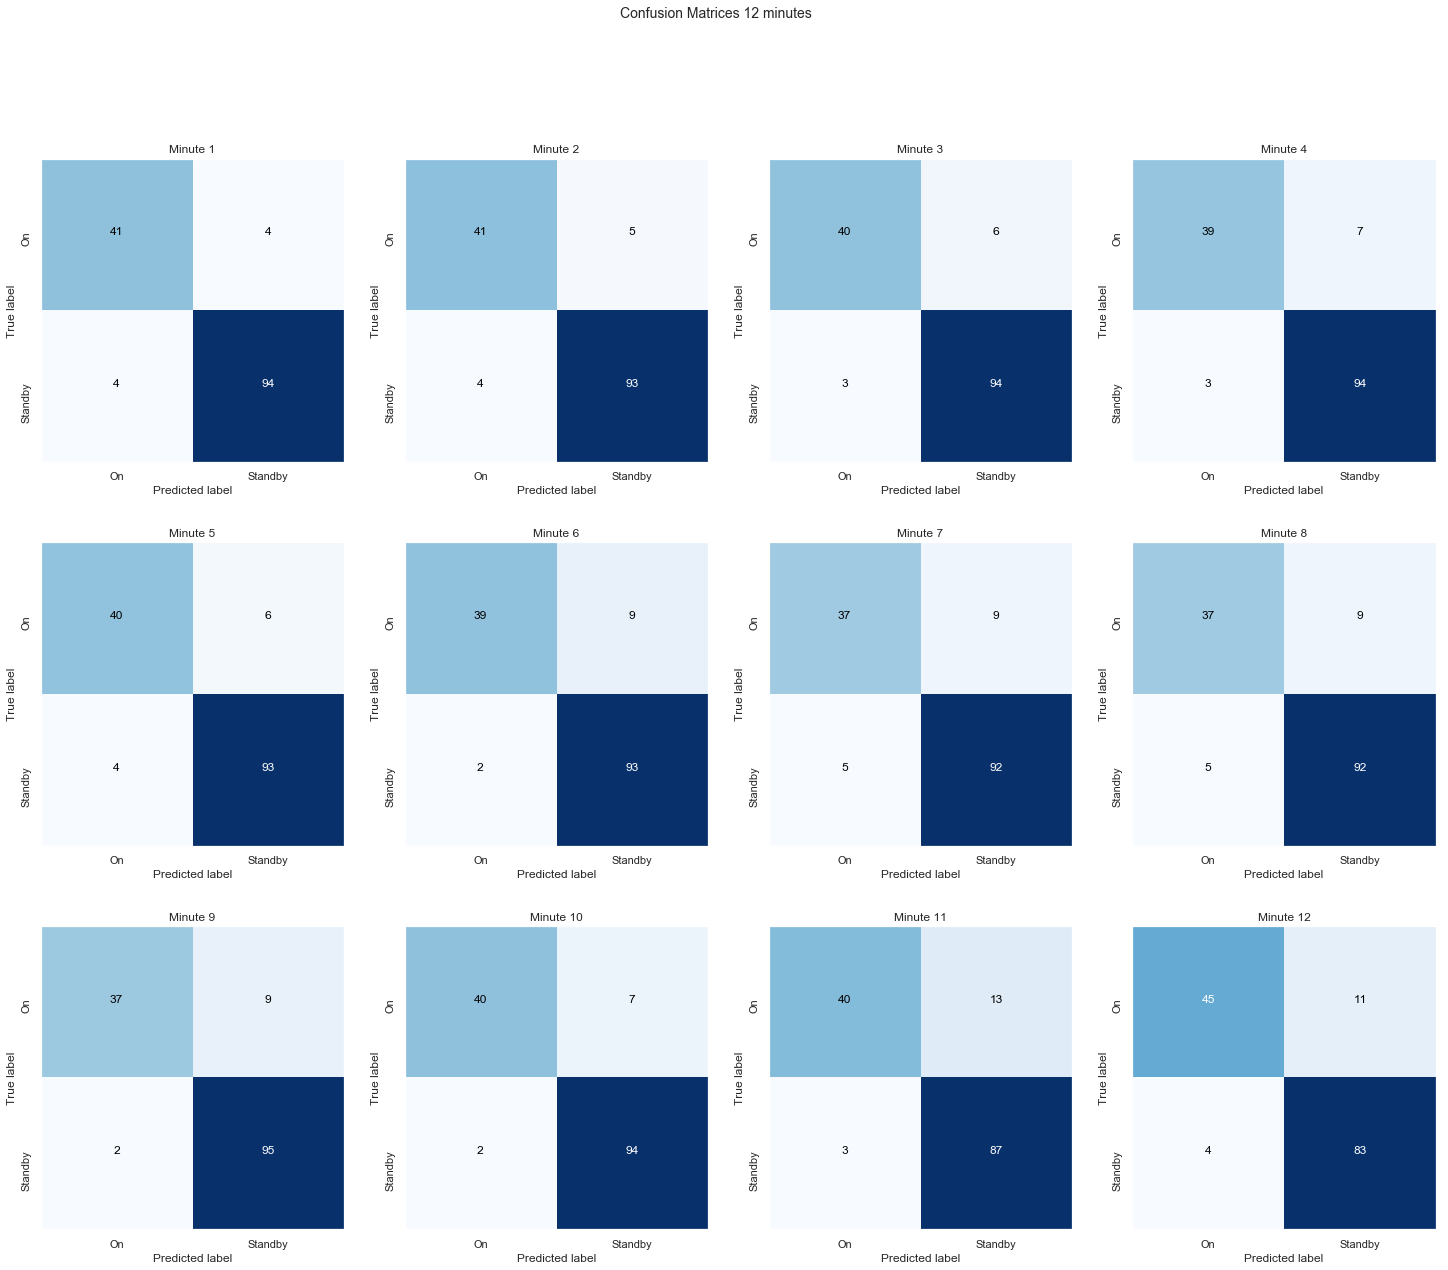

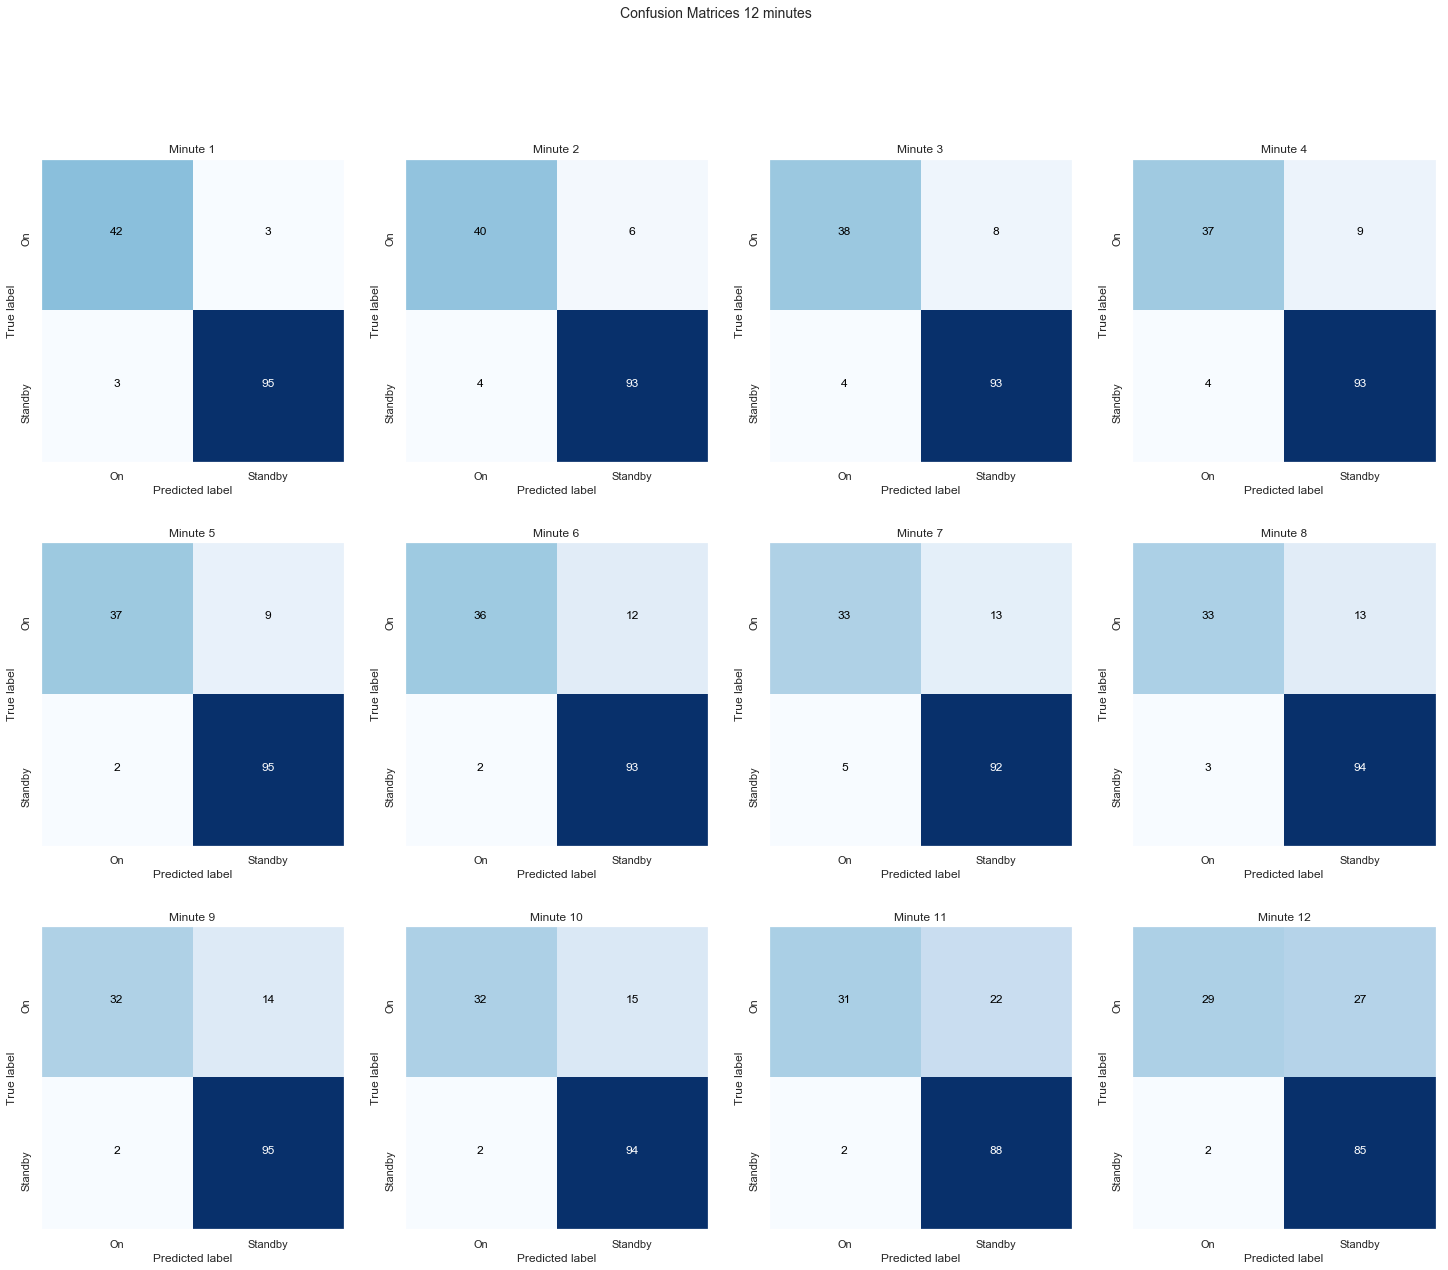

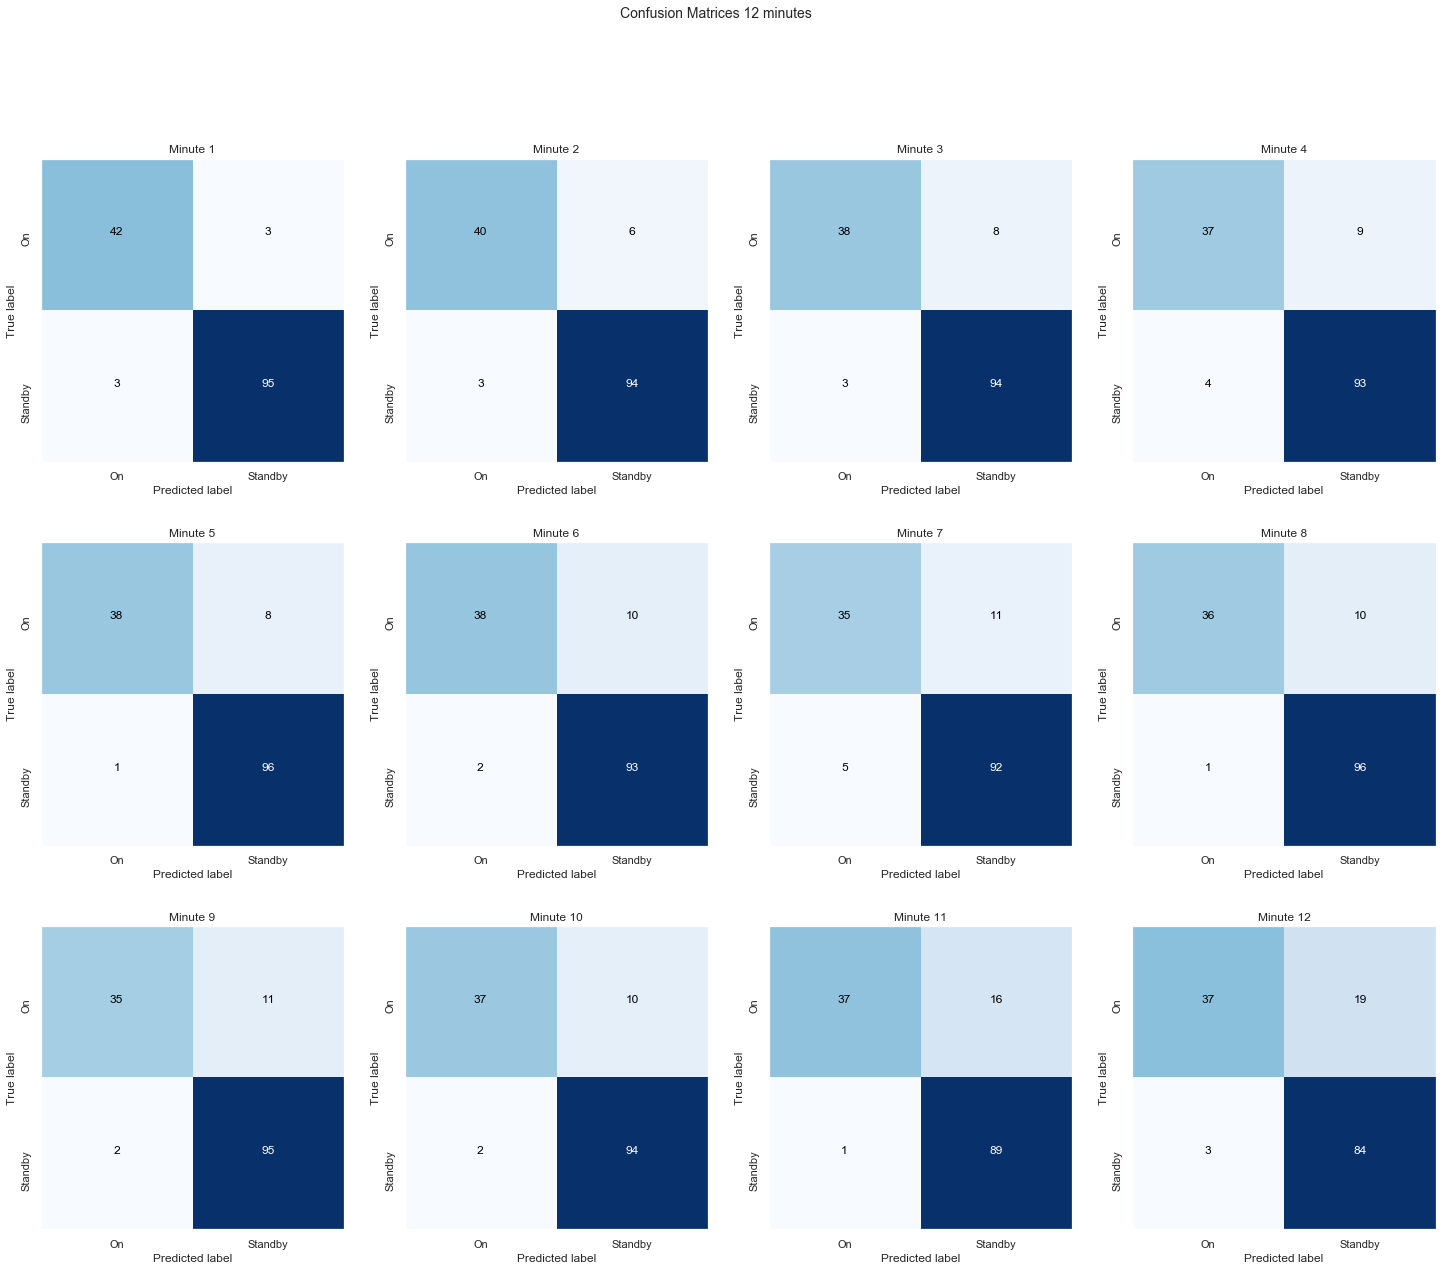

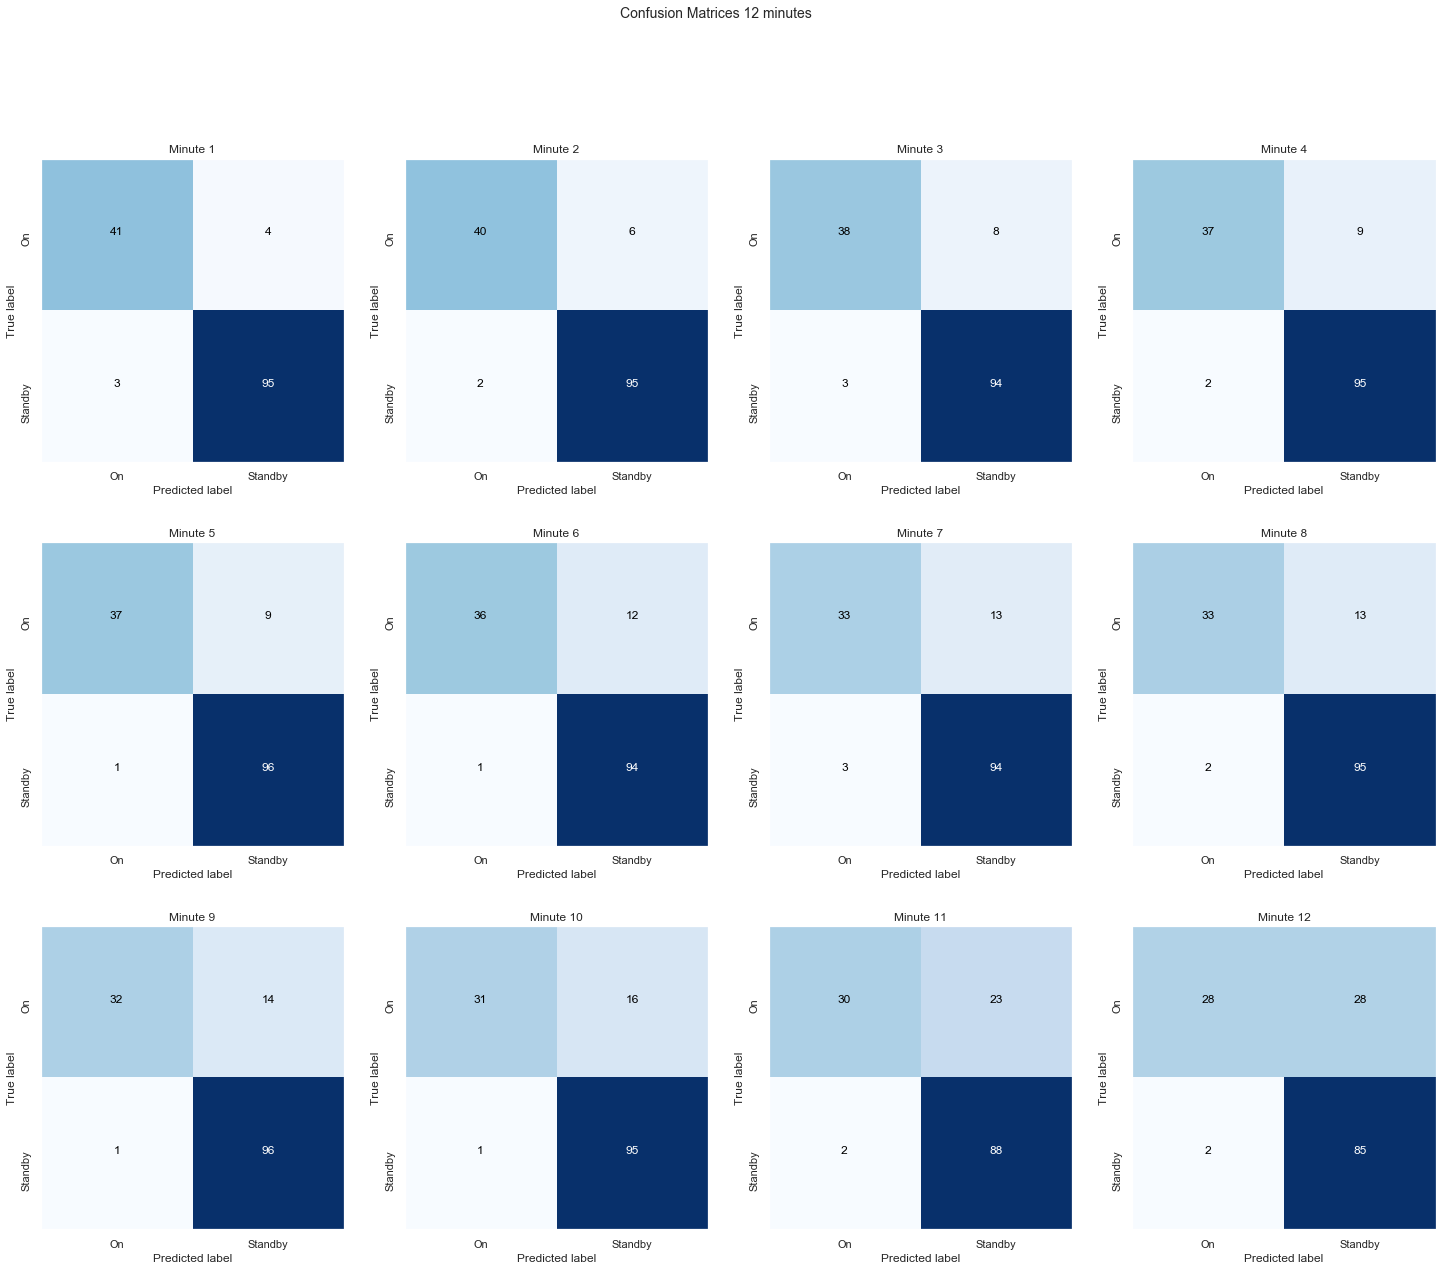

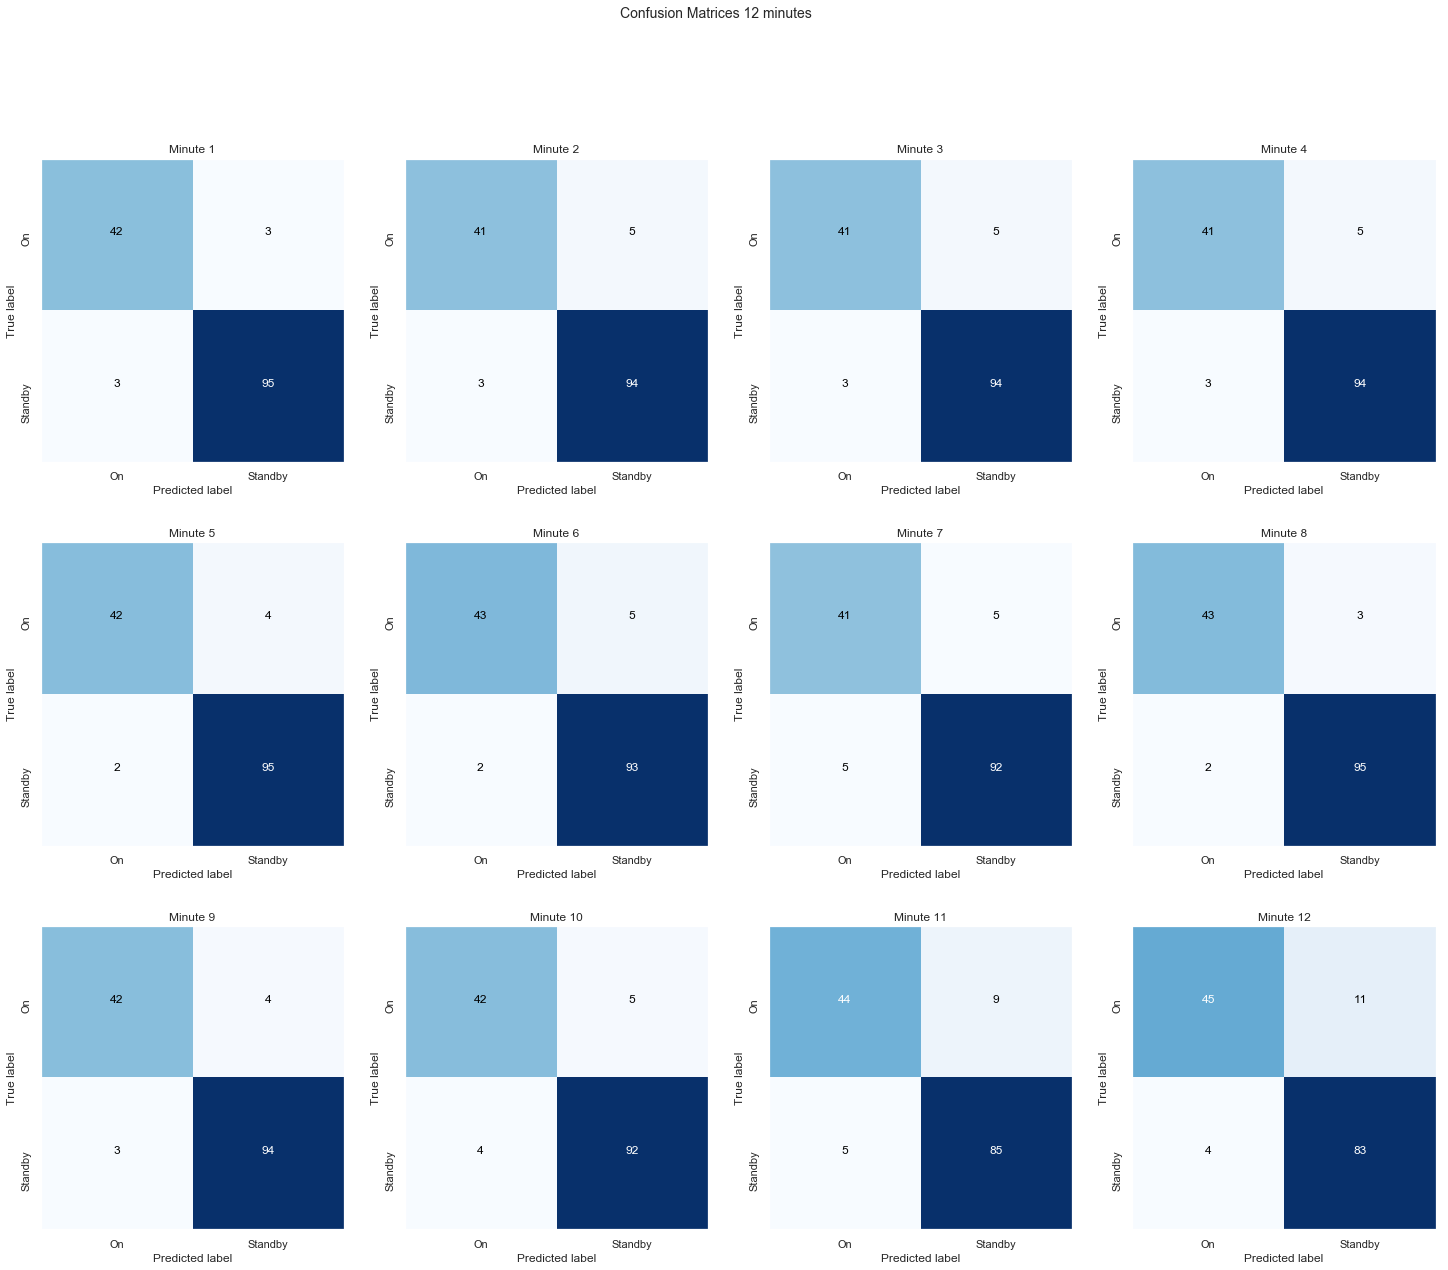

In [47]:
# load the new file
dataset = read_csv('cfreezer_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


PREDICT_LENGTH = 60 # This variable controls the number of hours to forecast

# split into train and test
train, test = split_dataset(dataset.values[:,1])

# prepare the models to evaluate
models = get_models()
n_input = PREDICT_LENGTH


# evaluate each model

next_minute = list()
for i in range(PREDICT_LENGTH):
    next_minute.append(str(i+1))

fig1, ax1 = pyplot.subplots()
fig2, ax2 = pyplot.subplots()
fig3, ax3 = pyplot.subplots()
fig4, ax4 = pyplot.subplots()

fig1.set_size_inches(20, 5)
fig2.set_size_inches(20, 5)
fig3.set_size_inches(20, 5)
fig4.set_size_inches(20, 5)

for name, model in models.items():
    
    print('\n Now evaluating '+name + '...\n')
    
    # evaluate and get scores
    accuracy, f1, precision, recall = evaluate_model(model, train, test, n_input)
    
    metrics_df = pd.DataFrame(list(zip(accuracy, f1, precision, recall)), 
               columns =['accuracy', 'f1', 'precision', 'recall'])
    metrics_df.to_csv('./Thesis _Notebooks/Classifiacation/Results/'+name + '_metrics -'+str(PREDICT_LENGTH)+'.csv')
                              
    
    # summarize scores
    summarize_scores(name, accuracy, f1, precision, recall)
    # plot metrics

    yticks=[round(x * 0.1,1) for x in range(0, 11)]
           

    ax1.plot(next_minute, accuracy, marker='o', label=name)    
    ax2.plot(next_minute, f1, marker='o', label=name)
    ax3.plot(next_minute, precision, marker='o', label=name)
    ax4.plot(next_minute, recall, marker='o', label=name)
    
    ax1.set_yticks(yticks)
    ax2.set_yticks(yticks)
    ax3.set_yticks(yticks)
    ax4.set_yticks(yticks)
    
    # title and labels, setting initial sizes
    fig1.suptitle('Accuracy of the Forecast', fontsize=12)
    ax1.set_xlabel('Next n\'th Hour', fontsize=10)
    ax1.set_ylabel('Accuracy', fontsize='medium')
    
    fig2.suptitle('F1 Score of the Forecast', fontsize=12)
    ax2.set_xlabel('Next n\'th Hour', fontsize=10)
    ax2.set_ylabel('F1 Score', fontsize='medium')
    
    fig3.suptitle('Precision of the Forecast', fontsize=12)
    ax3.set_xlabel('Next n\'th Hour', fontsize=10)
    ax3.set_ylabel('Precision', fontsize='medium')
    
    fig4.suptitle('Recall of the Forecast', fontsize=12)
    ax4.set_xlabel('Next n\'th Hour', fontsize=10)
    ax4.set_ylabel('Recall', fontsize='medium')
    
    pyplot.savefig('./Thesis _Notebooks/Classification/Results/'+name+'_ConfusionMatrix -'+str(PREDICT_LENGTH)+'.pdf')
                   
# show plot
fig1.legend()
fig1.savefig('./Thesis _Notebooks/Classification/Results/Accuracy -'+str(PREDICT_LENGTH)+'.pdf')
fig1.show()

fig2.legend()
fig2.savefig('./Thesis _Notebooks/Classification/Results/F-Score -'+str(PREDICT_LENGTH)+'.pdf')
fig2.show()

fig3.legend()
fig3.savefig('./Thesis _Notebooks/Classification/Results/Precision -'+str(PREDICT_LENGTH)+'.pdf')
fig3.show()

fig4.legend()
fig4.savefig('./Thesis _Notebooks/Classification/Results/Recall -'+str(PREDICT_LENGTH)+'.pdf')
fig4.show()

pyplot.show()

## Rough Work